In [224]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import sepfir2d,convolve2d
from scipy.ndimage import convolve


#### cv.imread using BGR format but plt using RGB format

(770, 1401, 3)


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [115,  79,   3, ...,   0,   0,   0],
       ...,
       [114, 151, 234, ..., 112, 114, 115],
       [117, 154, 238, ..., 109, 111, 112],
       [120, 157, 242, ..., 107, 108, 110]], dtype=uint8)

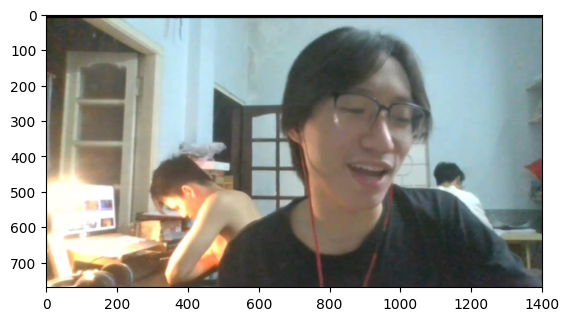

In [284]:
img = cv.imread('./img/bai1.png')
b,g,r=cv.split(img)
img=cv.merge((r,g,b))
plt.imshow(img)
print(img.shape)
b

# Negative Image

## Before

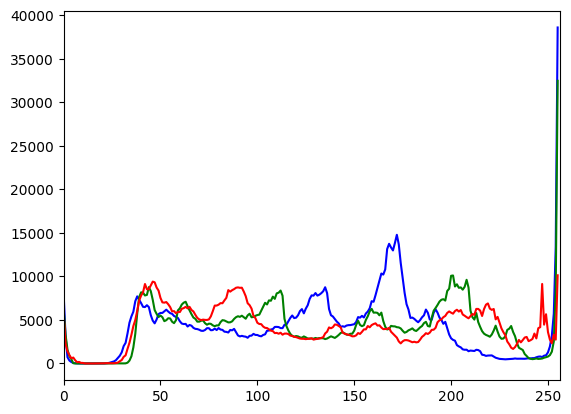

In [27]:
color = ('b', 'g', 'r') 
  
for i, col in enumerate(color): 
      
    histr = cv.calcHist([img],  
                         [i], None, 
                         [256],  
                         [0, 256]) 
      
    plt.plot(histr, color = col) 
      
    # Limit X - axis to 256 
    plt.xlim([0, 256]) 
      
plt.show() 

## After

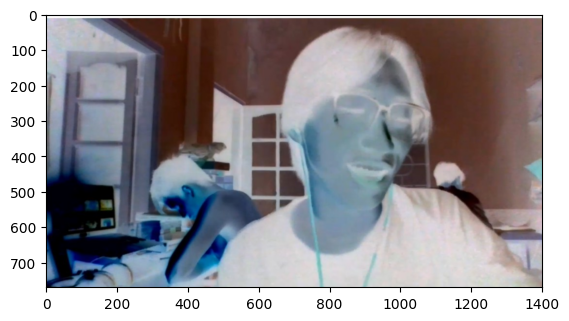

In [68]:
img1=img.copy()
# Slow
# height,width,_=img1.shape
# for i in range(0,height-1):
#     for j in range(0,width-1):
#         pixel=img1[i,j]
#         # red
#         pixel[0] = 255 - pixel[0]
#         # green
#         pixel[1] = 255 - pixel[1]
#         # blue
#         pixel[2] = 255 - pixel[2]
#         # Store new values in the pixel
#         img1[i, j] = pixel
#Vectorize
img1=255-img1
plt.imshow(img1)
plt.show()

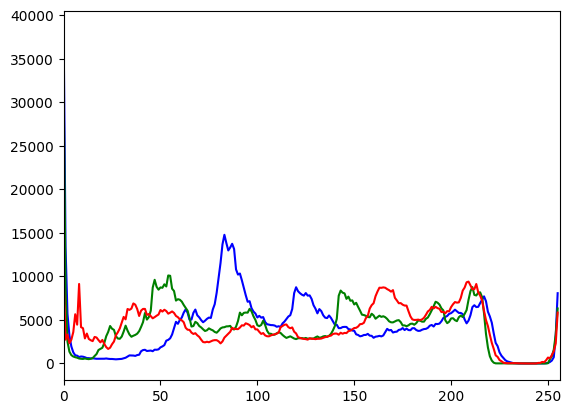

In [37]:
color = ('b', 'g', 'r') 
  
for i, col in enumerate(color): 
      
    histr = cv.calcHist([img1],  
                         [i], None, 
                         [256],  
                         [0, 256]) 
      
    plt.plot(histr, color = col) 
      
    # Limit X - axis to 256 
    plt.xlim([0, 256]) 
      
plt.show() 

# Gaussian filter

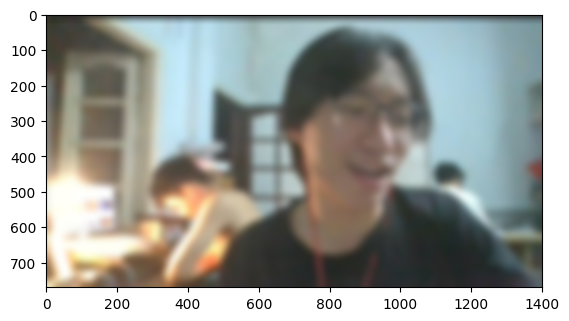

In [301]:
gauss_blurred = cv.GaussianBlur(img, (41, 41), sigmaX=10, sigmaY=10)#rule of thumb: k=2*pi*sigma
plt.imshow(gauss_blurred)

# Median filter

In [ ]:
# Áp dụng bộ lọc trung vị để lọc nhiể.u muô/i tiểu
noise_mask = np.random.randint(0, 21, size = (img.shape[0],
img.shape[1]), dtype=int)
zeros_pixel = np.where(noise_mask == 0)
one_pixel = np.where(noise_mask == 20)
pepper_salt_img = img.copy()
pepper_salt_img[zeros_pixel] = [0, 0, 0]
pepper_salt_img[one_pixel] = [255, 255, 255]
plt.imshow(pepper_salt_img)
plt.show()
median_blurred = cv.medianBlur(pepper_salt_img, 3)
plt.imshow(median_blurred)

# Sobel filter

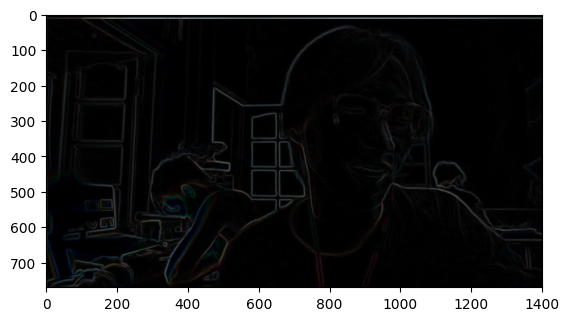

In [60]:
# Áp dụng bộ lọc Sobel 
img_gray = img.copy()
grad_x = cv.Sobel(src=img_gray, ddepth=cv.CV_64F, dx=1, dy=0,
ksize=5)
grad_y = cv.Sobel(src=img_gray, ddepth=cv.CV_64F, dx=0, dy=1,
ksize=5)
grad = np.sqrt(grad_x**2 + grad_y**2)
sobel = (grad * 255 / grad.max()).astype(np.uint8) # grảd normảlized
plt.imshow(sobel)

# Laplacian filter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


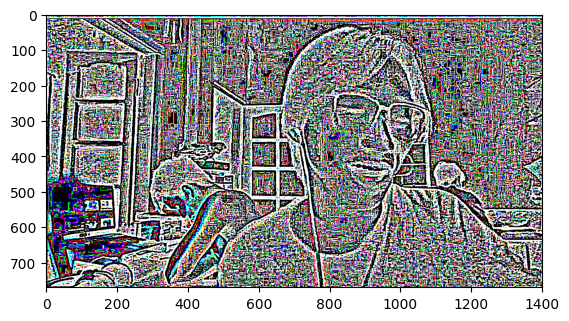

In [61]:
laplacian = cv.Laplacian(img_gray, ddepth=cv.CV_64F, ksize=5)
plt.imshow(laplacian)

# Gaussian Pyramid
## Using blur+downsample for each level to get down to new image with lower size

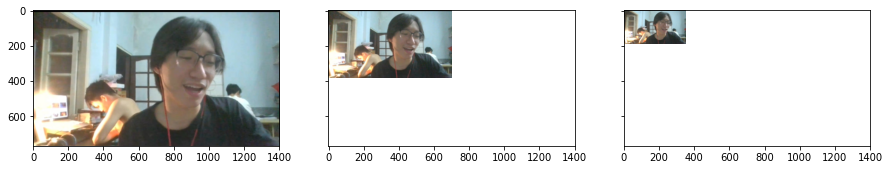

In [42]:
im_pyramid = img.copy()
N=3 # number of pyramid levels
P=[]
P.append(im_pyramid) # first pyramid level
for k in range(1,N): # build pyramid
    im2=np.zeros(im_pyramid.shape)
    im2 = cv.GaussianBlur(im_pyramid, (5, 5), sigmaX=3, sigmaY=3)
    im2=im2[::2,::2,:]# down sample
    im_pyramid=im2
    P.append(im2)
#display pyramid
fig,ax=plt.subplots(nrows=1,ncols=N,figsize=(15,7),dpi=72,sharex=True,sharey=True)
for k in range(N-1,-1,-1):
    ax[k].imshow(P[k])


# Laplacian Pyramid

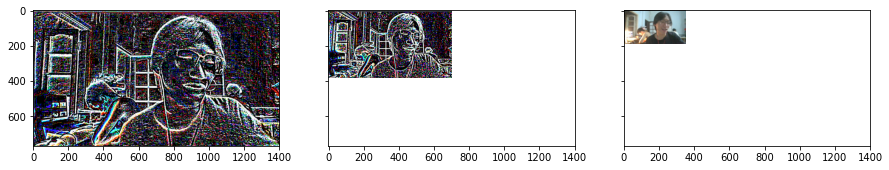

In [51]:
L=[]
for k in range(0,N-1):#pyramid levels
    l1=P[k]
    l2=P[k+1]
    l2=cv.resize(l2,(l1.shape[1],l1.shape[0])) # up-sample
    D=l1-l2
    D=D-np.min(D) #scale in [0,1]
    D=D/np.max(D) # for display purposes
    L.append(D)
L.append(P[N-1])
#display pyramid
fig,ax=plt.subplots(nrows=1,ncols=N,figsize=(15,7),dpi=72,sharex=True,sharey=True)
for k in range(N-1,-1,-1):
    ax[k].imshow(L[k])

# Steerable Pyramid

(770, 1401, 3)

# Wavelet Pyramid

# Delve into Gaussian Blur

In [294]:
def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)
 
 
def gaussian_kernel(size, sigma=1, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    kernel_1D = dnorm(kernel_1D, 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
 
    kernel_2D *= 1.0 / kernel_2D.max()
 
    if verbose:
        plt.imshow(kernel_2D, interpolation='none', cmap='gray')
        plt.title("Kernel ( {}X{} )".format(size, size))
        plt.show()
 
    return kernel_2D

In [265]:
def convolution(image, kernel, average=False, verbose=False):
    if len(image.shape) == 3:
        print("Found 3 Channels : {}".format(image.shape))
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        print("Converted to Gray Channel. Size : {}".format(image.shape))
    else:
        print("Image Shape : {}".format(image.shape))
 
    print("Kernel Shape : {}".format(kernel.shape))
 
    if verbose:
        plt.imshow(image, cmap='gray')
        plt.title("Image")
        plt.show()
 
    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape
 
    output = np.zeros(image.shape)
 
    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)
 
    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))
 
    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image
 
    if verbose:
        plt.imshow(padded_image, cmap='gray')
        plt.title("Padded Image")
        plt.show()
 
    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]
 
    print("Output Image size : {}".format(output.shape))
 
    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("Output Image using {}X{} Kernel".format(kernel_row, kernel_col))
        plt.show()
 
    return output
def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)
 
 
def gaussian_kernel(size, sigma=1, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
 
    kernel_2D *= 1.0 / kernel_2D.max()
 
    if verbose:
        plt.imshow(kernel_2D, interpolation='none', cmap='gray')
        plt.title("Kernel ( {}X{} )".format(size, size))
        plt.show()
 
    return kernel_2D
 
 
def gaussian_blur(image, kernel_size, verbose=False):
    kernel = gaussian_kernel(kernel_size, sigma=np.sqrt(kernel_size), verbose=verbose)
    return convolution(image, kernel, average=True, verbose=verbose)
 

### Without normalizing kernel

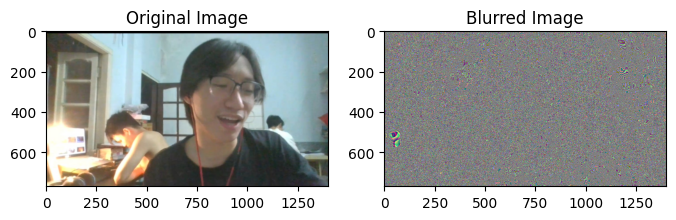

In [316]:

# Define the Gaussian kernel size and standard deviation
kernel_size = 60
sigma = 20

# Create a 2D Gaussian kernel
kernel = gaussian_kernel(kernel_size,sigma)


# Apply the Gaussian filter to each color channel separately
blurred_image = np.zeros_like(img, dtype=np.float32)
for i in range(3):
    blurred_image[:, :, i] = convolve(img[:, :, i], kernel)

# Alternatively, you can use the built-in gaussian_filter function


# Display the original and blurred images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(blurred_image.astype(int))
plt.title('Blurred Image')

plt.show()


### With normalizing kernel

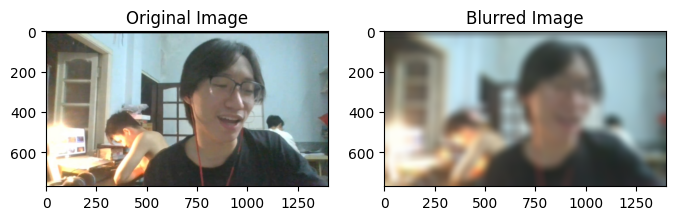

In [320]:

# Define the Gaussian kernel size and standard deviation
kernel_size = 61
sigma = 20

# Create a 2D Gaussian kernel
kernel = gaussian_kernel(kernel_size,sigma)

# Normalize the kernel to make the sum equal to 1. 
kernel_normalized = kernel/ np.sum(kernel) 

# Apply the Gaussian filter to each color channel separately
blurred_image = np.zeros_like(img, dtype=np.float32)
for i in range(3):
    blurred_image[:, :, i] = convolve(img[:, :, i], kernel_normalized)

# Alternatively, you can use the built-in gaussian_filter function


# Display the original and blurred images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(blurred_image.astype(int))
plt.title('Blurred Image')

plt.show()


# Separable Gaussian

### Faster than 2D kernel above

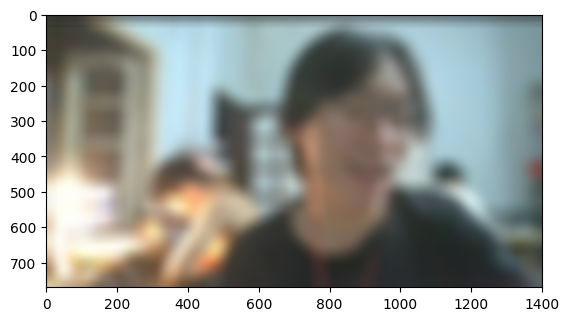

In [341]:
U,D,V=np.linalg.svd(kernel_normalized)
column_vector=U[:,0]
row_vector=V[0,:]*D[0]
convimg=np.zeros_like(img,dtype=np.float32)
for i in range(3):
    convimg[:,:,i]=sepfir2d(1.0*img[:,:,i],column_vector,row_vector)
plt.imshow(convimg.astype(int))
plt.show()
# plt.imshow(convimg.astype(int)-gauss_blurred)

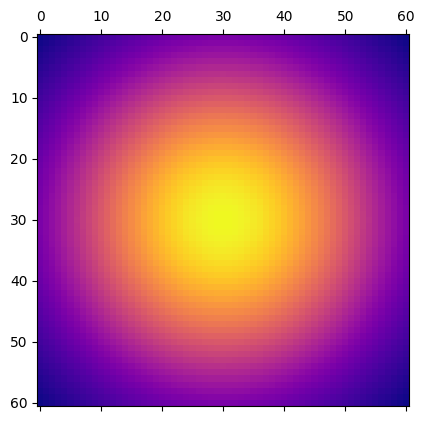

In [340]:
plt.matshow(np.hstack((kernel,)), cmap='plasma')

# Lowpass filter in Frequency domain

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


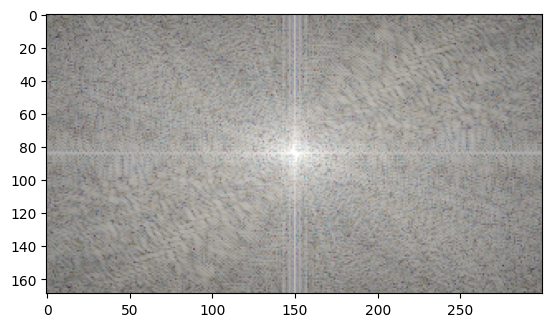

array([[[107.42333301, 113.28046638, 102.30164423],
        [135.70587571, 134.77481926, 128.14239364],
        [122.97057634, 119.93645063, 117.09162991],
        ...,
        [139.33493055, 134.63800579, 134.18368139],
        [133.28585841, 131.87690817, 130.04420173],
        [124.85473046, 126.02656687, 124.60365938]],

       [[125.34046838, 125.20543981, 121.70946049],
        [ 95.11613858, 101.87063684, 112.10405982],
        [143.00536358, 142.95959077, 138.86437724],
        ...,
        [130.44427485, 123.9948984 , 121.77512977],
        [133.66584458, 129.0697567 , 121.55475439],
        [105.83643475,  99.98870322, 108.95314168]],

       [[113.71244067, 106.55954677, 109.3879584 ],
        [133.95669105, 129.88621147, 127.77656267],
        [126.49504992, 126.64113409, 122.7178133 ],
        ...,
        [133.23942003, 127.10538086, 128.18386372],
        [133.54740524, 130.66663432, 129.97484669],
        [142.30643305, 140.13266641, 137.56016399]],

       ...,

      

In [80]:
img_h = cv.imread('./img/Shinichi_Kudo.png')
img_h = cv.cvtColor(img_h, cv.COLOR_BGR2RGB)
fft_c1 = np.fft.fftshift(np.fft.fft2(img_h[:,:,0]))
fft_c2 = np.fft.fftshift(np.fft.fft2(img_h[:,:,1]))
fft_c3 = np.fft.fftshift(np.fft.fft2(img_h[:,:,2]))
fft_img = np.dstack((fft_c1, fft_c2, fft_c3))
fft_img = 20*np.log(abs(fft_img))
plt.imshow(fft_img.astype(int),cmap='plasma') 
plt.show()  
fft_img
# muy, sigma_t = (0, 23)
# # cut off frequency
# h, w = (img.shape[0], img.shape[1])
# sigma_f_x = w / (2 * np.pi * sigma_t)
# sigma_f_y = h / (2 * np.pi * sigma_t)
# x = np.tile(np.arange(- w // 2, - w // 2 + w), [h, 1])
# y = np.transpose(np.tile(np.arange(- h // 2, - h // 2 + h), [w, 1]))
# gauss_blurred_msk = np.exp(- (x**2 + y**2) / (2 * sigma_f_x *
# sigma_f_y) )
# print(gauss_blurred_msk)
# filtered_fft_c1 = gauss_blurred_msk * fft_c1
# filtered_fft_c2 = gauss_blurred_msk * fft_c2
# filtered_fft_c3 = gauss_blurred_msk * fft_c3
# filtered_fft_img = np.dstack((filtered_fft_c1, filtered_fft_c2,
# filtered_fft_c3))
# filtered_fft_img = 20*np.log(abs(filtered_fft_img))
# plt.imshow(filtered_fft_img) 
# plt.show()  
# filtered_fft_c1 = np.fft.ifftshift(filtered_fft_c1)
# filtered_fft_c2 = np.fft.ifftshift(filtered_fft_c2)
# filtered_fft_c3 = np.fft.ifftshift(filtered_fft_c3)
# ifft_img_c1 = np.fft.ifft2(filtered_fft_c1).astype(float)
# ifft_img_c2 = np.fft.ifft2(filtered_fft_c2).astype(float)
# ifft_img_c3 = np.fft.ifft2(filtered_fft_c3).astype(float)
# ifft_img = np.dstack((ifft_img_c1, ifft_img_c2, ifft_img_c3))
# plt.imshow(ifft_img)
# plt.show()  
# # accuracy
# plt.imshow(abs(ifft_img - gauss_blurred))